# OpenML Cheat Sheet (Python)

In [124]:
# General imports
from openml import datasets, tasks, runs, flows, config, evaluations, study
import os, pandas, sklearn, arff, pprint, numpy, seaborn

## config

Find your API key (required for uploads):
* `www.openml.org` > Your profile > API Authentication

Main OpenML servers:
* Public: `https://www.openml.org/api/v1` (default)
* Test: `https://test.openml.org/api/v1` 

Set server, API key and cache directory (default: `~/.openml/cache`)

Or, create a config file called `~/.openml/config`
and add these lines:

In [ ]:
server=https://www.openml.org/api/v1
apikey=qxlfpbeaudtprb23985hcqlfoebairtd
cachedir=/homedir/.openml/cache

## datasets  
**`list_datasets(offset=None, size=None, tag=None)`**
* `offset` and `size` for paging results
* `tag` to filter datasets (e.g. 'uci')
* `status`: active, in_preparation, deactivated
* `data_name`, `data_version`, `number_instances`,...

In [39]:
dlist = datasets.list_datasets(size=100)
pandas.DataFrame.from_dict(dlist, orient='index')[
['name','NumberOfInstances', 'NumberOfFeatures']][:3]

,name,NumberOfInstances,NumberOfFeatures
2,anneal,898,39
3,kr-vs-kp,3196,37
4,labor,57,17


**`get_dataset(dataset_id)`**
* returns **OpenMLDataset** object
* automatically downloads and caches the data itself

In [4]:
odata = datasets.get_dataset(1471)
print(odata.name, "Target: "+ odata.default_target_attribute, 
      odata.description[260:308], sep='\n')

eeg-eye-state
Target: Class
All data is from one continuous EEG measurement 


**`OpenMLDataset`**  

**`.features`**: list of features and their properties  
**`.qualities`**: list of all dataset properties  
**`.get_data`**(target,return_attribute_names=False,return_categorical_indicator=False):  
  returns data as numpy arrays, attribute names, and which are categorical  
**`.retrieve_class_labels(target_name='class')`**: return all class labels for the given target attribute



In [100]:
X, y, attribute_names = odata.get_data(
    target=odata.default_target_attribute, 
    return_attribute_names=True)
pandas.DataFrame(X, columns=attribute_names)[:2]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,4329.229980,4009.229980,4289.229980,4148.209961,4350.259766,4586.149902,4096.919922,4641.029785,4222.049805,4238.459961,4211.279785,4280.509766,4635.899902,4393.850098
1,4324.620117,4004.620117,4293.850098,4148.720215,4342.049805,4586.669922,4097.439941,4638.970215,4210.770020,4226.669922,4207.689941,4279.490234,4632.819824,4384.100098


**Upload new datasets**
* Create a new OpenML dataset with all relevant information
* `datasets.functions.create_dataset` for uploading pandas dataframes or numpy arrays
* Call **`.publish()`** to upload

In [46]:
md = datasets.OpenMLDataset(data_file='dataset.arff', name='t',
    description='t', version='1', format='ARFF', licence='CC0',
    visibility='public', default_target_attribute='class')
data_id = md.publish()

print("New dataset ID: " + str(data_id)) 

New dataset ID: 6677


## tasks  
**`list_tasks(task_type_id=None, offset=None, size=None, ...)`**
* `offset` and `size` for paging results, `tag` to filter tags
* `task_type_id`: 1=Classification, 2=Regression,...
* Dataset properties: `data_tag`, `status`, `data_id`, `data_name`, `number_instances`, `number_features`, `number_classes`, ...

In [103]:
tlist = tasks.list_tasks(task_type_id=1, size=100)
pandas.DataFrame.from_dict(tlist, orient='index')[
['name','estimation_procedure']][:3]

,name,estimation_procedure
2,anneal,10-fold Crossvalidation
3,kr-vs-kp,10-fold Crossvalidation
4,labor,10-fold Crossvalidation


**`get_task(task_id)`**
* returns **OpenMLTask** object
    *  includes estimation procedure, target name, cost matrix,...
* automatically caches the task description

In [8]:
task = tasks.get_task(14951)
pprint.pprint(task.estimation_procedure)

{'data_splits_url': 'https://www.openml.org/api_splits/get/14951/Task_14951_splits.arff',
 'parameters': {'number_folds': '10',
                'number_repeats': '1',
                'percentage': '',
                'stratified_sampling': 'true'},
 'type': 'crossvalidation'}


**`OpenMLTask`**  
**`.get_dataset()`**: downloads associated dataset   
**`.download_split()`**: downloads train/test splits

**Create new tasks**  
...  
`Under development`

## flows  
**`list_flows(offset=None, size=None, tag=None, uploader=None)`**
* returns ID -> flow dict mapping
* `offset` and `size` for paging results, `tag` to filter tags
* `uploader`: list of uploader IDs to filter on, e.g. [1,2,3]

In [102]:
flist = flows.list_flows(size=200)
pandas.DataFrame.from_dict(flist, orient='index')[
    ['name','version','external_version']][100:102]

,name,version,external_version
101,moa.WEKAClassifier_REPTree,1,Moa_2014.03_1.0
102,weka.REPTree,2,Weka_3.7.5_9378


**`sklearn_to_flow(sklearn_estimator)`**

* converts a scikit-learn estimator or pipeline to an OpenML Flow

**`publish()`**

* Uploads the flow to the server. Returns ID

In [10]:
lr = sklearn.linear_model.LinearRegression().fit(X, y)
flow = flows.sklearn_to_flow(lr)

pipe = sklearn.pipeline.Pipeline(steps=[
    ('Imputer', sklearn.preprocessing.Normalizer()),
    ('Classifier', sklearn.linear_model.LinearRegression())])
flow2 = flows.sklearn_to_flow(pipe)
# flows.publish(flow)

## runs  
**`list_runs(offset=None, size=None, tag=None, id=None, task=None, flow=None, uploader=None, display_errors=False)`**
* `offset` and `size` for paging results, `tag` to filter tags
* `id`, `task`, `flow`, `uploader`: list of IDs to filter, e.g. [1,2,3]
* `display_errors`: whether to return failed runs

In [104]:
rl = runs.list_runs(task=[14951],size=100)
pandas.DataFrame.from_dict(rl, orient='index')[1:5]

,run_id,task_id,setup_id,flow_id,uploader
544514,544514,14951,5540,3404,2
595116,595116,14951,6436,4074,2
595117,595117,14951,6436,4074,2
595118,595118,14951,6436,4074,2


**`get_run(run_id)`**
* returns **OpenMLRun** object
    *  includes the exact task, exact flow, and all evaluations
* automatically caches the run description

**OpenMLRun**  
**.uploader_name**: full name of the run author  
**.flow_name**: full name of the flow  
**.parameter_settings**: hyperparameters of the flow  
**.evaluations**: key-value pairs of metric and score  
**.fold_evaluations**: dict of per-fold evaluations  

In [32]:
rlist = runs.list_runs(task=[14951],size=50)
scores = []
for id, _ in rlist.items():
    run = runs.get_run(id)
    scores.append({"flow":run.flow_name, 
                   "score":run.evaluations['area_under_roc_curve']})
pandas.DataFrame.from_dict(scores)[17:20]

,flow,score
17,sklearn.tree.tree.DecisionTreeClassifier(2),0.842479
18,sklearn.ensemble.forest.RandomForestClassifier...,0.964900
19,mlr.classif.rpart(11),0.693537


**`run_flow_on_task(flow, task)`**  
**`run_model_on_task(model, task)`**

* Runs a flow or model (e.g. sklearn model) on the task
* Returns a **OpenMLRun** with all information
* Trains and tests the flow of all train/test splits defined by the task

**`publish()`**
* Publishes the run on OpenML


In [128]:
task = tasks.get_task(14951)
clf = sklearn.linear_model.LogisticRegression()
run = runs.run_model_on_task(clf, task)
score = run.get_metric_fn(sklearn.metrics.accuracy_score)
myrun = run.publish()

print(myrun)
print("Accuracy: {:.2f}%".format(score.mean()))

[run id: 10154999, task id: 14951, flow id: 9652, flow name: sklearn.linear_model.logis...]
Accuracy: 0.64%


## evaluations  
**`list_evaluations(function=None, offset=None, size=None, tag=None, id=None, task=None, flow=None, uploader=None, display_errors=False)`**
* `function`: evaluation measure, e.g. `area_under_roc_curve'
* `offset` and `size` for paging results, `tag` to filter tags
* `id`, `task`, `flow`, `uploader`: list of IDs to filter, e.g. [1,2,3]
* `per_fold`: if True, returns per-fold evaluations 
* `setup`: list of hyperparameter setup ID's

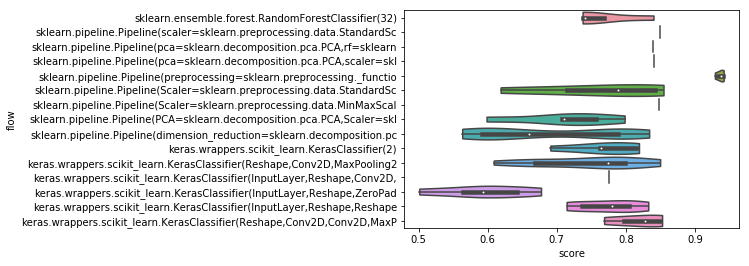

In [138]:
evals = evaluations.list_evaluations(task=[167133], 
    function='area_under_roc_curve', size=100)
scores = [{"flow":e.flow_name[0:70], "score":e.value} 
          for id, e in evals.items()]
seaborn.violinplot(x="score", y="flow", cut=0, scale="width", 
                   data=pandas.DataFrame(scores));

## Benchmark suites
* Curated collections of tasks for benchmarking
* Run any model or pipeline on all tasks
* Frictionless evaluation and sharing

In [131]:
benchmark_suite = study.get_study('OpenML-CC18','tasks')
clf = sklearn.linear_model.LogisticRegression()
for task_id in benchmark_suite.tasks[0:2]: # take small subset
    run = runs.run_model_on_task(clf, tasks.get_task(task_id))
    score = run.get_metric_fn(sklearn.metrics.accuracy_score)
    print('Data set: %s; Accuracy: %0.2f' % (task.get_dataset().name,score.mean()))
    # run.publish()

Data set: kr-vs-kp; Accuracy: 0.96
Data set: letter; Accuracy: 0.72


In [55]:
from IPython.display import set_matplotlib_formats, display, HTML
HTML('''<style>.prompt {display:none;}
        .output_subarea pre{width:130%}
        </style>''')

In [96]:
config.server = 'https://www.openml.org/api/v1'